In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
bucket ='bert-readability'
data_key = 'text-classification/complaints.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:xlabel='Company_response_to_consumer'>

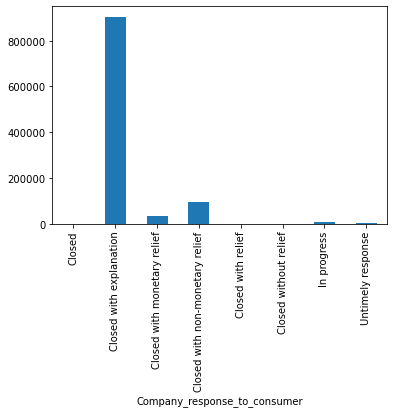

In [5]:
df.groupby(['Company_response_to_consumer']).size().plot.bar()

In [4]:
df.shape

(1048575, 18)

In [6]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'Date_received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Subproduct':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub_issue':'SUB_ISSUE',
                  'Consumer_complaint_narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company_public_response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer_consent_provided':'CONSUMER_CONSENT_PROVIDED',
                   'Subbmited via':'SUBMITTED_VIA',
                   'Date_sent_to_company':'DATE_SENT_TO_COMPANY',
                   'Company_response_to_consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely_response':'TIMELY_RESPONSE',
                   'Consumer_disputed':'CONSUMER_DISPUTED',
                   'Complaint_ID':'COMPLAINT_ID'
                  }, inplace=True)



In [8]:
# Percentage of missing column values
null_check_percent = df.isnull().sum() * 100 / len(df)
null_check_percent

DATE_RECEIVED                    0.000000
PRODUCT                          0.000000
SUB_PRODUCT                      0.732709
ISSUE                            0.000000
SUB_ISSUE                       11.340152
CONSUMER_COMPLAINT_NARRATIVE    52.257206
COMPANY_PUBLIC_RESPONSE         49.292802
COMPANY                          0.000000
STATE                            1.579477
ZIP_code                         1.592256
TAGS                            88.417519
CONSUMER_CONSENT_PROVIDED       11.936390
Submitted via                    0.000000
DATE_SENT_TO_COMPANY             0.000000
COMPANY_RESPONSE_TO_CONSUMER     0.000286
TIMELY_RESPONSE                  0.000000
CONSUMER_DISPUTED               97.616861
COMPLAINT_ID                     0.000000
dtype: float64

# Dropping all rows that do not have Customer Complaint entries in them

Dropping all rows that do not have Customer Complaint entries in them

In [10]:
# remove articles with missing "CONSUMER_COMPLAINT_NARRATIVE"
df = df.dropna(subset = ['CONSUMER_COMPLAINT_NARRATIVE'])
df = df.reset_index(drop = True)
null_check_percent = df.isnull().sum() * 100 / len(df)
null_check_percent


DATE_RECEIVED                    0.000000
PRODUCT                          0.000000
SUB_PRODUCT                      0.784229
ISSUE                            0.000000
SUB_ISSUE                       14.255951
CONSUMER_COMPLAINT_NARRATIVE     0.000000
COMPANY_PUBLIC_RESPONSE         51.433126
COMPANY                          0.000000
STATE                            0.496585
ZIP_code                         0.528146
TAGS                            84.484608
CONSUMER_CONSENT_PROVIDED        0.000000
Submitted via                    0.000000
DATE_SENT_TO_COMPANY             0.000000
COMPANY_RESPONSE_TO_CONSUMER     0.000200
TIMELY_RESPONSE                  0.000000
CONSUMER_DISPUTED               97.439370
COMPLAINT_ID                     0.000000
dtype: float64

In [11]:
df.shape

(500619, 18)

In [12]:
1048575 - 500619  # all_complaints - complaints with narratives =  complaints without narratives (547956)

547956

<AxesSubplot:xlabel='COMPANY_RESPONSE_TO_CONSUMER'>

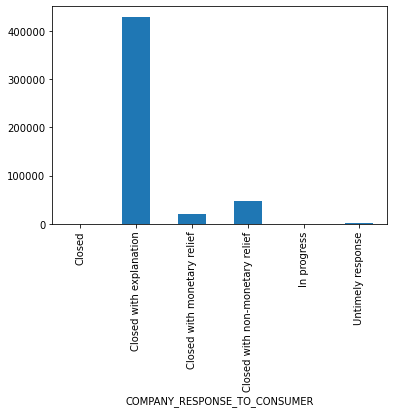

In [13]:
df.groupby(['COMPANY_RESPONSE_TO_CONSUMER']).size().plot.bar()

From the above graph, we will focus on 2 categories only:
1. Closed with monetary relief
2. Closed with non-monetary relief

# Subsetting Dataframe for Text Multi-Classification Problem

In [14]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_response_and_complaint = df[['COMPANY_RESPONSE_TO_CONSUMER', 'CONSUMER_COMPLAINT_NARRATIVE']]

# Renaming columns to something easier
df_response_and_complaint.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 
df.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [15]:
df.head(1)

,DATE_RECEIVED,PRODUCT,SUB_PRODUCT,ISSUE,SUB_ISSUE,CONSUMER_COMPLAINT,COMPANY_PUBLIC_RESPONSE,COMPANY,STATE,ZIP_code,TAGS,CONSUMER_CONSENT_PROVIDED,Submitted via,DATE_SENT_TO_COMPANY,COMPANY_RESPONSE_TO_CONSUMER,TIMELY_RESPONSE,CONSUMER_DISPUTED,COMPLAINT_ID
0,18-08-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"TransUnion, LLC conducted an investigation int...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,90640.0,NaN,Consent provided,Web,18-08-2019,Closed with explanation,Yes,NaN,3345092


In [16]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_response_and_complaint = df[['COMPANY_RESPONSE_TO_CONSUMER', 'CONSUMER_COMPLAINT']]

In [17]:
df_response_and_complaint.head(3)

,COMPANY_RESPONSE_TO_CONSUMER,CONSUMER_COMPLAINT
0,Closed with explanation,"TransUnion, LLC conducted an investigation int..."
1,Closed with explanation,I have recently been informed again that there...
2,Closed with explanation,In XXXX I had a loan modification with wellsfa...


In [ ]:
import pickle 

# # Pickling our subsetted dataframe
with open('df_response_and_complaint.pickle', 'wb') as to_write:
     pickle.dump(df_response_and_complaint, to_write)

In [ ]:
# Loading our pickled subsetted dataframe
with open('df_response_and_complaint.pickle', 'rb') as to_read:
    df_response_and_complaint = pickle.load(to_read)

# Understanding/Cleaning Our Data

In [18]:
# Checking our dataframe
df_response_and_complaint.info()

# Great! We have no null values in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500619 entries, 0 to 500618
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   COMPANY_RESPONSE_TO_CONSUMER  500618 non-null  object
 1   CONSUMER_COMPLAINT            500619 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [19]:
# Pre-drop category value_counts
df_response_and_complaint.COMPANY_RESPONSE_TO_CONSUMER.value_counts()

Closed with explanation            429229
Closed with non-monetary relief     47583
Closed with monetary relief         20814
Untimely response                    2620
Closed                                350
In progress                            22
Name: COMPANY_RESPONSE_TO_CONSUMER, dtype: int64

In [20]:
# Dropping rows with the aggregated columns
df_response_and_complaint.drop(
    df_response_and_complaint[
    df_response_and_complaint.COMPANY_RESPONSE_TO_CONSUMER == 
    'In progress'].index, 
    inplace=True) # In progress  

df_response_and_complaint.drop(
    df_response_and_complaint[
    df_response_and_complaint.COMPANY_RESPONSE_TO_CONSUMER == 
    'Closed'].index, 
    inplace=True) # Closed  

df_response_and_complaint.drop(
    df_response_and_complaint[
    df_response_and_complaint.COMPANY_RESPONSE_TO_CONSUMER == 
    'Untimely response'].index, 
    inplace=True) # Untimely response


df_response_and_complaint.drop(
    df_response_and_complaint[
    df_response_and_complaint.COMPANY_RESPONSE_TO_CONSUMER == 
    'Closed with explanation'].index, 
    inplace=True) # Closed with explanation 

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
df_response_and_complaint.COMPANY_RESPONSE_TO_CONSUMER.value_counts()

Closed with non-monetary relief    47583
Closed with monetary relief        20814
Name: COMPANY_RESPONSE_TO_CONSUMER, dtype: int64

In [22]:
# Reducing dataframe to 30k entries
# Need to reduce non-monetory categories by 56.26%
# ( 20814 /  47583) x 100 =  43.74%     and, (100 - ) = 56.26%
percentage_reduction = 0.5626

# Debt Collection Reduction
df_response_and_complaint_reduced = \
df_response_and_complaint.drop(
    df_response_and_complaint[df_response_and_complaint['COMPANY_RESPONSE_TO_CONSUMER'] == 'Closed with non-monetary relief'].sample(frac=percentage_reduction).index)

In [23]:
df_response_and_complaint_reduced.COMPANY_RESPONSE_TO_CONSUMER.value_counts()

Closed with monetary relief        20814
Closed with non-monetary relief    20813
Name: COMPANY_RESPONSE_TO_CONSUMER, dtype: int64

Text(0.5, 0, 'NUMBER OF COMPLAINTS')

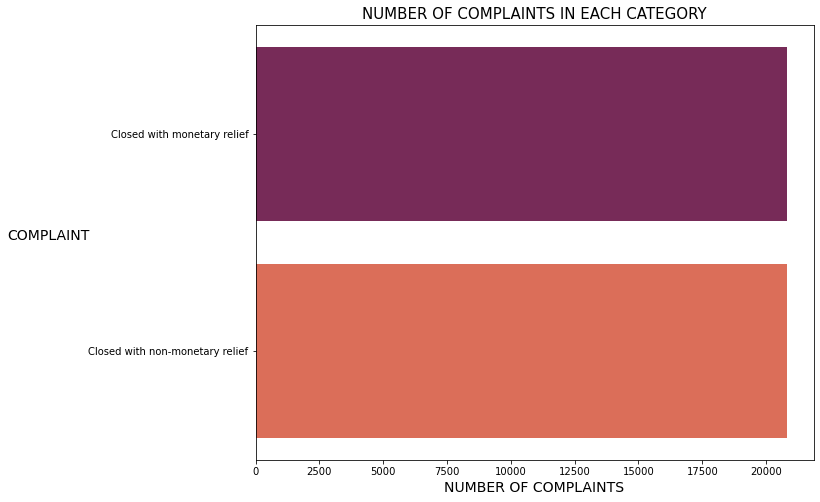

In [24]:
# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='COMPANY_RESPONSE_TO_CONSUMER', 
                   data=df_response_and_complaint_reduced, 
                   order=df_response_and_complaint_reduced['COMPANY_RESPONSE_TO_CONSUMER'].value_counts().index,
                   palette='rocket'     # change the color of this graph LATER   
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

# Label Encoding Categories

In [52]:
# Applying encoding to the COMPANY_RESPONSE_TO_CONSUMER column
df_response_and_complaint_reduced['COMPANY_RESPONSE_CATEGORY'] = df_response_and_complaint_reduced['COMPANY_RESPONSE_TO_CONSUMER'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the COMPANY_RESPONSE_TO_CONSUMER column


# Creates a dataframe of the COMPANY_RESPONSE_TO_CONSUMER to their respective COMPANY_RESPONSE_CATEGORY
category_id_df = df_response_and_complaint_reduced[['COMPANY_RESPONSE_TO_CONSUMER', 'COMPANY_RESPONSE_CATEGORY']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a COMPANY_RESPONSE_TO_CONSUMER: COMPANY_RESPONSE_CATEGORY key-value pair
id_to_category = dict(category_id_df[['COMPANY_RESPONSE_CATEGORY', 'COMPANY_RESPONSE_TO_CONSUMER']].values)  # Creates a COMPANY_RESPONSE_CATEGORY: COMPANY_RESPONSE_TO_CONSUMER key-value pair

# New dataframe
df_response_and_complaint_reduced.head(10) 

# Closed with non-monetary relief --> 0
# Closed with monetary relief --> 1



,COMPANY_RESPONSE_TO_CONSUMER,CONSUMER_COMPLAINT,COMPANY_RESPONSE_CATEGORY
15,Closed with monetary relief,On XX/XX/10 my account was negative about {$8....,0
23,Closed with monetary relief,MoneyLion told the CFPB on XX/XX/XXXX that the...,0
32,Closed with monetary relief,In XX/XX/2019 I did not receive my billing sta...,0
33,Closed with non-monetary relief,I applied for credit at my credit union and th...,1
61,Closed with non-monetary relief,"I received a collection attempt from "" XXXX XX...",1
67,Closed with non-monetary relief,IhavespokenwithNavientcustomerservicetoaskabou...,1
80,Closed with monetary relief,Google ( 1 ) suspended my payments account wit...,0
87,Closed with non-monetary relief,Wells Fargo is reporting incorrect accounts to...,1
91,Closed with monetary relief,XX/XX/19 Contacted Capital One Dispute Resolut...,0
97,Closed with monetary relief,On XX/XX/XXXX I tried to make a balance transf...,0


In [103]:
# Column Cleaning First. Columns are super nastily named
df_response_and_complaint_reduced.rename(columns={'COMPANY_RESPONSE_TO_CONSUMER':'category',
                  'CONSUMER_COMPLAINT':'text'
                  }, inplace=True)

In [111]:
df_response_and_complaint_reduced.head(3)

,category,text,COMPANY_RESPONSE_CATEGORY
15,Closed with monetary relief,On XX/XX/10 my account was negative about {$8....,0
23,Closed with monetary relief,MoneyLion told the CFPB on XX/XX/XXXX that the...,0
32,Closed with monetary relief,In XX/XX/2019 I did not receive my billing sta...,0


In [107]:
import pickle
# # Pickling reduced dataframe
with open('df_response_and_complaint_reduced.pickle', 'wb') as to_write:
     pickle.dump(df_response_and_complaint_reduced, to_write)

In [191]:
# Loading Pickled DataFrame
with open('df_response_and_complaint_reduced.pickle', 'rb') as to_read:
    df = pickle.load(to_read)

In [192]:
df.head(3)

,category,text,COMPANY_RESPONSE_CATEGORY
15,Closed with monetary relief,On XX/XX/10 my account was negative about {$8....,0
23,Closed with monetary relief,MoneyLion told the CFPB on XX/XX/XXXX that the...,0
32,Closed with monetary relief,In XX/XX/2019 I did not receive my billing sta...,0


In [193]:
# Dropping column COMPANY_RESPONSE_CATEGORY
df.drop("COMPANY_RESPONSE_CATEGORY",axis=1,inplace=True)

In [213]:
df.head(1)

,category,text
15,Closed with monetary relief,On XX/XX/10 my account was negative about {$8....


In [159]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'COMPANY_RESPONSE_CATEGORY':'category'
                  }, inplace=True)

In [160]:
df.head(3)

,text,category
15,On XX/XX/10 my account was negative about {$8....,0
23,MoneyLion told the CFPB on XX/XX/XXXX that the...,0
32,In XX/XX/2019 I did not receive my billing sta...,0


In [219]:
# Text cleaning packages
import nltk 
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [220]:
nltk.download('stopwords')
nltk.download('wordnet')
def lem_words(text):
    text = text.split()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    return text

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


In [221]:
df['text'] = df.text.apply(func=make_lower_case)
df['text'] = df.text.apply(func=remove_stop_words)
df['text'] = df.text.apply(func=remove_punctuation)
df['text'] = df.text.apply(func=lem_words)
df

,category,text
15,Closed with monetary relief,xx xx 10 account negative 8 00 due pending tra...
23,Closed with monetary relief,moneylion told cfpb xx xx xxxx would issue bon...
32,Closed with monetary relief,xx xx 2019 receive billing statement sent wron...
33,Closed with non-monetary relief,applied credit credit union application declin...
61,Closed with non-monetary relief,received collection attempt xxxx xxxx xxxx all...
...,...,...
500546,Closed with monetary relief,xx xx 2016 received notice on line payment xxx...
500586,Closed with non-monetary relief,send credit bureau letter informing received c...
500604,Closed with non-monetary relief,filed complaint experian vacate public record ...
500606,Closed with monetary relief,xx xx 2017 contacted individual told serving s...


In [238]:
# Percentage of missing column values
null_check_percent = df.isnull().sum() * 100 / len(df)
null_check_percent

category    0.002402
text        0.000000
dtype: float64

In [239]:
# remove articles with missing "category"
df = df.dropna(subset = ['category'])
df = df.reset_index(drop = True)
null_check_percent = df.isnull().sum() * 100 / len(df)
null_check_percent


category    0.0
text        0.0
dtype: float64

In [240]:
df['text'] = df.text.astype(str)

In [241]:
df.head(3)

,category,text
0,Closed with monetary relief,xx xx 10 account negative 8 00 due pending tra...
1,Closed with monetary relief,moneylion told cfpb xx xx xxxx would issue bon...
2,Closed with monetary relief,xx xx 2019 receive billing statement sent wron...


In [242]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Closed with non-monetary relief':0,
          'Closed with monetary relief':1,
          }

In [243]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [244]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, len(labels))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [245]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [246]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [247]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

33301 4163 4163


In [ ]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 81%|████████▏ | 13541/16651 [1:53:38<25:11,  2.06it/s] 

In [ ]:
evaluate(model, df_test)

# Saving & Loading Model for Inference

In [ ]:
#bucket ='bert-readability'
#data_key = 'text-classification'
#data_location = 's3://{}/{}'.format(bucket, data_key)


In [ ]:
torch.save(model.state_dict(), data_location)

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(data_location))
model.eval()  